In [2]:
#some imports

import numpy as np
from numpy import random
from numpy import linalg
from scipy.spatial import distance

import matplotlib.pyplot as plt

random.seed(0)

In [3]:
#This function plots the contourline func(x) = value
def plot_contour_line(func, value=0, x_values=np.empty(0)):
    
    minx = -1
    maxx = 2
    miny = -1
    maxy = 2
    
    #print(np.array(x_values.shape))
    if (np.array(x_values.shape)[1] ==2):
        x_values = x_values.T
    
    # sets minx, etc. if x_values is a two-dimensoinal array of values
    if np.array(x_values.shape).shape[0] > 1:
        dim = np.array(x_values.shape)[0]
        if dim==2:
            minx = ((int)(np.amin(x_values[0])))-1.5
            maxx = ((int)(np.amax(x_values[0])))+1.5
            miny = ((int)(np.amin(x_values[1])))-1.5
            maxy = ((int)(np.amax(x_values[1])))+1.5
    samplenum = 100
    xrange = np.arange(minx, maxx, (maxx-minx)/samplenum)
    yrange = np.arange(miny, maxy, (maxy-miny)/samplenum)
    
    #This generates a two-dimensional mesh
    X, Y = np.meshgrid(xrange,yrange)
    # print(X,Y)
    
    argsForf = np.array([X.flatten(),Y.flatten()]).T
    Z = func(argsForf)
    Z = np.reshape(Z,X.shape)
    
    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.contour(X, Y, Z, alpha=0.5,levels=[value],linestyles='dashed',linewidths=3)
    Z = np.where(Z > value, 1, -1)
    plt.contourf(X, Y, Z, alpha=0.2, cmap=plt.cm.coolwarm)

-------------------------------------------
# Task 2.1
We implement the one step minimialisation algorithm for the sequential minimal optimization. 

In [4]:
def one_step(beta, y, x, b, i, j, C):
    """beta: (n); y: (n); x: (n, d); b, i, j, C scalar"""
    #beta_old = np.zeros(0, n)
    #beta_old[j] = beta[j]
    #beta_old[i] = beta[i]
    
    f = lambda xk: np.multiply(beta, y) @ (x @ xk) + b
    delta = y[i]*((f(x[j])-y[j]) - (f(x[i])-y[i]))
    s = y[i] * y[j]
    chi = x[i] @ x[i] + x[j] @ x[j] - 2 * (x[i] @ x[j])
    gamma = s*beta[i] + beta[j]
    if s==1:
        if gamma - C > 0:
            L = gamma - C
            H = C
        else:
            L = 0
            H = gamma
    else:
        if gamma > 0:
            L = 0
            H = C - gamma
        else:
            L = -gamma
            H = C
    if chi > 0:
        if beta[i] + delta / chi > L:
            if beta[i] + delta / chi > H:
                beta[i] = H
            else:
                beta[i] = beta[i] + delta / chi
        else:
            if L > H:
                beta[i] = H
            else:
                beta[i] = L
    elif delta > 0:
        beta[i] = L
    else:
        beta[i] = H
    beta[j] = gamma - s*beta[i]
    f = lambda xk: np.multiply(beta, y) @ (x @ xk) + b
    b = b - 1/2*(f(x[i]) - y[i] + f(x[j]) - y[j])
    return b, beta

--------------------
# Task 2.2
We create exponentialy distributed test data.

In [5]:
def create_test_data(d = 2, n = 40, lambda_1 = 4, lambda_2 = 0.5, lable_1 = -1, lable_2 = 1):
    x_group_1 = np.random.exponential(1/lambda_1, (int)(n/2 * d)).reshape(((int)(n/2), d))
    x_group_2 = np.random.exponential(1/lambda_2, (int)(n/2 * d)).reshape(((int)(n/2), d))
    x = np.vstack((x_group_1, x_group_2))
    y = np.hstack((np.full((int)(n/2), lable_1), np.full((int)(n/2), lable_2)))
    return x, y

------------------------------------------
# Task 2.3
We calculate our SMO model with iteration. Initialize beta and b with 0 and work with one_step function.

In [6]:
def sequential_minimal_optimization(x, y, C, iterations = 10000):
    """optimize the classification with SMO. 
    Enter x_k values in x of shape (n, d), y values of shape (n). C>0 is the regularization."""
    ## task a
    b = 0
    beta = np.zeros(x.shape[0])
    
    for k in np.arange(0, iterations):
        i = np.random.randint(0, x.shape[0])
        j = np.random.randint(0, x.shape[0]-1)
        if j>=i:
            j += 1
        b, beta = one_step(beta, y, x, b, i, j, C)
        
    ## task b
    f = lambda xk: np.multiply(beta.T, y) @ (x @ xk.T) + b
    med = np.median(np.subtract(f(x[beta>0]), y[beta>0]))
    b -= med
    
    
    f = lambda xk: np.multiply(beta.T, y) @ (x @ xk.T) + b
    return f, beta

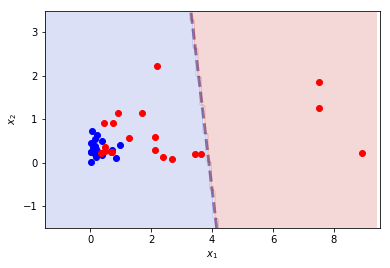

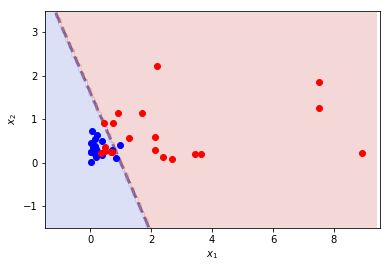

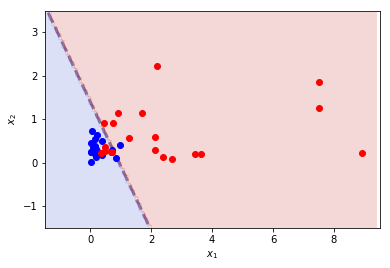

In [7]:
x, y = create_test_data()
for C in (0.01, 1, 100):
    f, beta = sequential_minimal_optimization(x, y, C)
    plt.plot(x[:20,0], x[:20,1], 'bo')
    plt.plot(x[20:,0], x[20:,1], 'ro')
    plot_contour_line(f, 0, x)
    plt.show()

In [8]:
# task c + d
def get_support_and_margin_defining_verctors(x, beta, C, n):
        is_support_vector = beta>0
        is_margin_defining_vector = np.logical_and(is_support_vector, C>beta)
        return x[is_support_vector], x[is_margin_defining_vector]

C: 0.01
38 support vectors
2 margin defining vectors


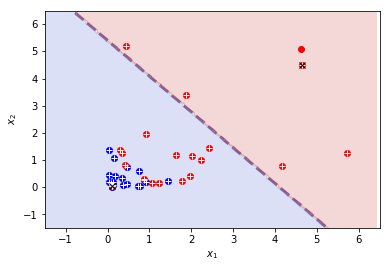

C: 1
19 support vectors
3 margin defining vectors


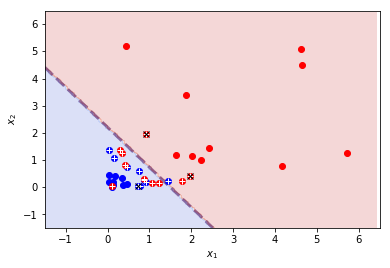

C: 100
18 support vectors
5 margin defining vectors


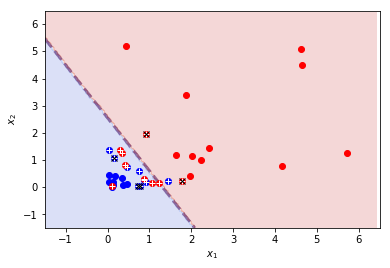

In [9]:
x, y = create_test_data()

for C in (0.01, 1, 100):
    f, beta = sequential_minimal_optimization(x, y, C)
    sup_vec, marg_vec = get_support_and_margin_defining_verctors(x, beta, C, 40)
    print("C: " + str(C))
    print(str(sup_vec.shape[0]) + " support vectors")
    print(str(marg_vec.shape[0]) + " margin defining vectors")
    plt.plot(x[:20,0], x[:20,1], 'bo')
    plt.plot(x[20:,0], x[20:,1], 'ro')
    plt.plot(sup_vec[:,0], sup_vec[:,1], 'w+')
    plt.plot(marg_vec[:,0], marg_vec[:,1], 'kx')
    plot_contour_line(f, 0, x)
    plt.show()

--------------
# Task 2.4
We get the LLS and tha accuracy form the first sheet. Then we plot the accuracys of the LLS model vs the various SVM with different C.

In [10]:
# copies from sheet 1
def generate_LLS_model(x,y):
    """x:(n,d); y:(n); output: (n)"""
    
    #reorganize the data in a matrix with the first row being (1,...,1)^T
    X_hat = np.asmatrix(np.hstack((np.ones((x.shape[0],1)),x)))

    #solve for the best alpha which mimimines ||X_hat * alpha - y||^2
    alpha = np.linalg.solve(X_hat.T @ X_hat, X_hat.T @ np.asmatrix(y).T)
    
    #implements the linear function based on the previously generated alpha
    f = lambda z: (alpha[0,0] + z @ alpha[1:]).flatten()
    
    return f


In [11]:

def classification_accuracy(data,label, classes,f,value = 0):
    """Calculates the accuracy of a 2 classes classification funcion f. Data : (n,d), label: (n), classes 2-tuple"""
        
    is_class_0 = f(data) < value
    is_class_1 = np.logical_not(is_class_0)
        
    
    label_0 = label == classes[0]
    label_1 = label == classes[1]
    correct_class_0 = np.count_nonzero(np.logical_and(label_0, is_class_0))
    correct_class_1 = np.count_nonzero(np.logical_and(label_1, is_class_1))
    
    
    return (correct_class_0 + correct_class_1)/(data.shape[0])

In [12]:
x, y = create_test_data(d = 2, n = 2000)
f_LLS = generate_LLS_model(x,y)

LLS_accuracy = classification_accuracy(x,y,(-1,1),f_LLS)

for C in (0.01, 1, 100):
    f_SMO, beta = sequential_minimal_optimization(x, y, C, iterations = 10000)
    print("--------------------------")
    print("C: " + str(C))
    print()
    
    print("LLS model:")
    print("accuracy: " + str(LLS_accuracy))
    
    print("SMO model:")
    print("accuracy: " + str(classification_accuracy(x,y,(-1,1),f_SMO,value=0)))
    print()
    
    """argsForf = np.array([X.flatten(),Y.flatten()]).T
    Z = func(argsForf)
    Z = np.reshape(Z,X.shape)
    
    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.contour(X, Y, Z, alpha=0.5,levels=[value],linestyles='dashed',linewidths=3)
    Z = np.where(Z > value, 1, -1)"""

--------------------------
C: 0.01

LLS model:
accuracy: 0.848
SMO model:
accuracy: 0.915

--------------------------
C: 1

LLS model:
accuracy: 0.848
SMO model:
accuracy: 0.9045

--------------------------
C: 100

LLS model:
accuracy: 0.848
SMO model:
accuracy: 0.899



----------------
# Task 2.6
We create a uniform distribution as instructed in the exercise. Then we use the linear SVM to calssify, followed by the non linear SVM using $\phi$

In [13]:
# This is actually not a uniform distribution. We tend to have a lot of points around (0,0)^T.

def generate_data_circle(n = 100, radius_1 = 1, radius_2 = 2, lable_1 = -1, lable_2 = 1):
    alpha = np.random.uniform(0, 2 * np.pi, n)
    
    r1 = np.random.uniform(0, radius_1, (int)(n/2))
    r2 = np.random.uniform(radius_1, radius_2, (int)(n/2))
    
    x_val1 = r1 * np.exp(alpha[: (int)(n/2)] * 1j)
    x_val2 = r2 * np.exp(alpha[(int)(n/2):] * 1j)
    
    y = np.hstack((np.full((int)(n/2), lable_1), np.full((int)(n/2), lable_2)))

    x = np.hstack((x_val1, x_val2))
    x = np.hstack((x.real.reshape(100, 1), x.imag.reshape(100, 1)))
    
    return x, y



In [15]:
def plot_generated_data(x):
    plt.plot(x[:len(x)//2,0], x[:len(x)//2,1], 'bo')
    plt.plot(x[len(x)//2:,0], x[len(x)//2:,1], 'ro')
    #return x, y

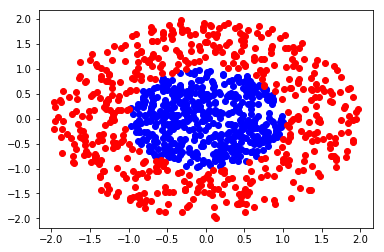

In [25]:

def generate_data_uniform(n,d, r1=1,r2=2,label_0=-1,label_1=1):
    R = max(r1,r2)
    r = min(r1,r2)
    data_1 = np.random.uniform(-r,r,(n//2,d))
    for i in range(len(data_1)):
        while np.dot(data_1[i],data_1[i])>r**2:
            #print("t")
            data_1[i] = np.random.uniform(-r,r, 2)
    
    data_2 = np.random.uniform(-R,R,(n-(n//2),d))
    for i in range(len(data_2)):
        while np.dot(data_2[i],data_2[i])<r**2 or np.dot(data_2[i],data_2[i])>R**2:
            #print("t")
            data_2[i] = np.random.uniform(-R,R, 2)
    return np.vstack((data_1,data_2))
            
x = generate_data_uniform(1000,2)
plot_generated_data(x)
plt.show()

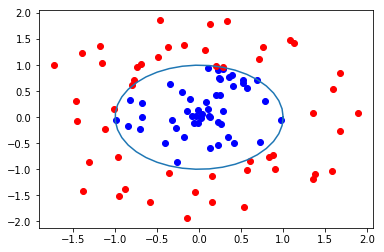

In [26]:
x, y = generate_data_circle()
#print(x.shape)

plot_generated_data(x)
lin = np.linspace(0,2*np.pi, 40)
sphere = np.exp(lin*1j)
plt.plot(sphere.real, sphere.imag)

Here we  plot the linear SVM

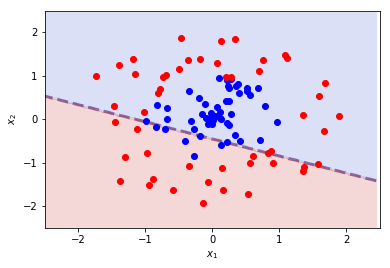

In [27]:
# task a

plot_generated_data(x)
f_1, beta = sequential_minimal_optimization(x, y, C = 10, iterations = 10000)
plot_contour_line(f_1, 0, x)

In [28]:
# task b
def phi(x):
    x0 = x[:,0].reshape(x.shape[0], 1)
    x1 = x[:,1].reshape(x.shape[0], 1)
    x2 = (np.add( np.square(x[:,0]) , np.square(x[:,1])) ).reshape(x.shape[0], 1)
    return np.hstack((x0,x1,x2))

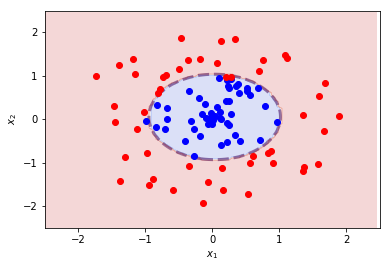

In [29]:

plot_generated_data(x)
x_phi = phi(x)

f_phi, beta = sequential_minimal_optimization(x_phi, y, C = 10, iterations = 10000)
plot_contour_line(lambda z: f_phi(phi(z)), 0, x)

---------------------------
# Task 2.7

We repeat the earlier steps with a kernel as new scalar product.

In [30]:
def one_step_kernel(beta, y, x, b, i, j, C, kernel):
    """beta: (n); y: (n); x: (n, d); b, n, i, j, C scalar"""
    #beta_old = np.zeros(0, n)
    #beta_old[j] = beta[j]
    #beta_old[i] = beta[i]
    
    f = lambda xk: np.multiply(beta, y) @ kernel(x, xk) + b
    delta = y[i]*((f(x[j])-y[j]) - (f(x[i])-y[i]))
    s = y[i] * y[j]
    
    #print (x[i].shape)
    
    chi = kernel(x[i], x[i]) + kernel(x[j], x[j]) - 2 * kernel(x[i], x[j])
    gamma = s*beta[i] + beta[j]
    if s==1:
        if gamma - C > 0:
            L = gamma - C
            H = C
        else:
            L = 0
            H = gamma
    else:
        if gamma > 0:
            L = 0
            H = C - gamma
        else:
            L = -gamma
            H = C
    if chi > 0:
        if beta[i] + delta / chi > L:
            if beta[i] + delta / chi > H:
                beta[i] = H
            else:
                beta[i] = beta[i] + delta / chi
        else:
            if L > H:
                beta[i] = H
            else:
                beta[i] = L
    elif delta > 0:
        beta[i] = L
    else:
        beta[i] = H
    beta[j] = gamma - s*beta[i]
    f = lambda xk: np.multiply(beta, y) @ kernel(x, xk) + b
    b = b - 1/2*(f(x[i]) - y[i] + f(x[j]) - y[j])
    return b, beta


In [31]:
def generate_SMO_kernel(x, y, C, kernel, iterations = 10000):
    """optimize the classification with SMO. 
    Enter x_k values in x of shape (n, d), y values of shape (n). C>0 is the regularization."""
    ## task a
    b = 0
    beta = np.zeros(x.shape[0])
    
    for k in np.arange(0, iterations):
        i = np.random.randint(0, x.shape[0])
        j = np.random.randint(0, x.shape[0]-1)
        if j>=i:
            j += 1
        b, beta = one_step_kernel(beta, y, x, b, i, j, C, kernel)
        
    ## task b
    f = lambda xk: np.multiply(beta, y) @ kernel(x, xk) + b
    
    med = np.median(np.subtract(f(x[beta>0]), y[beta>0]))
    #med = np.median(np.subtract(np.apply_along_axis(f, 1, x[beta>0]), y[beta>0]))
    
    b = b-med
    f = lambda xk: np.multiply(beta, y) @ kernel(x, xk) + b
    return f, beta

We define the gaussian kernel and apply it to our uniform data.

In [32]:
def gaussian_kernel(x,y,sigma = 1):
    """Calculates the gaussian kernel of x,y with sigma. 
    If x,y are (d) returns scalar.
    If x: (n,d) and y: (m,d) returns (n x m)-array with all kernel products
    """
    #print(type(y))
    
    if x.ndim == 1 and y.ndim == 1:
        return np.exp((-.5) * np.square(distance.euclidean(x,y)/sigma) )
    
    #reshape if dimensions do not fit
    if y.ndim == 1:
        y = y.reshape((1,2))
    elif x.ndim == 1:
        x = x.reshape((1,2))

    dists_squared = np.square( distance.cdist(x,y) / sigma )
    
    return np.exp((-.5) * dists_squared)

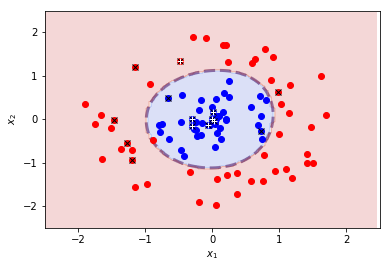

In [33]:
x, y = generate_data_circle()
C = 10

plot_generated_data(x)
plt.plot(x[beta>0,0],x[beta>0,1], 'kx')
plt.plot(x[np.logical_and(beta>0,beta<C),0],x[np.logical_and(beta>0,beta<C),1], 'w+')

f_SMO_kernel, beta = generate_SMO_kernel(x, y, C, lambda x,y: gaussian_kernel(x,y, sigma=1),iterations = 10000)
plot_contour_line(f_SMO_kernel, 0, x)

---------------------------
 # Task 2.8
 
 Unfortunately we did not finish task 2.8 in time. We had not enough time.

In [43]:
def k_cross_validation (k,x,y,sig_vals,C_vals):
    if k == 0: return None
    
    D_indices = np.array([(i%k) for i in np.arange(len(x))])
    np.random.shuffle(D_indices)
    
    A = np.zeros((len(sig_vals),len(C_vals)))
    for sig in range(len(sig_vals)):
        kernel = lambda x,t: gaussian_kernel(x,t, sigma=sig_vals[sig])
        for C in range(len(C_vals)):
            for i in range(k):
                f, beta = generate_SMO_kernel(x[D_indices!=i], y[D_indices!=i], C, kernel,iterations = 1000)
                A[sig,C] += classification_accuracy(x[D_indices==i],y[D_indices==i], (-1,1),f,value = 0)
            A[sig,C] /= k
            print("sigma:"+str(sig_vals[sig])+" C:"+str(C_vals[C])+" Accuracy:"+str(A[sig,C]))
    return
k_cross_validation(3,x,y,(1,10),(1,10))

/home/s_tep/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/s_tep/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/s_tep/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


sigma:1 C:1 Accuracy:0.5
sigma:1 C:10 Accuracy:0.9396910279263221
sigma:10 C:1 Accuracy:0.5
sigma:10 C:10 Accuracy:0.6283422459893048


In [44]:
#Load MNIST Data
import os
import gzip
from urllib.request import urlretrieve

from sklearn.svm import SVC
had 

def download(filename , source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename , filename)
    
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 28, 28)
    return data / np.float32(256)

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

NameError: name 'had' is not defined

In [ ]:
choice = (np.array([True]*500 + [False]*(len(X_train)-500)))
np.random.shuffle(choice)
print(choice)

X_500 = (X_train[choice])#.reshape(500,24**2)
X_500 = np.array([x for x in X_500]).reshape((500,28**2))

y_500 = (y_train[choice]).reshape(500)
print(X_500.shape)

model = SVC(gamma = 'auto')
model.fit(X_500,y_500)
#print(y_500)
for i in np.arange(0, 10):
    sieve = np.logical_not(y_500-i)